In [1]:
# Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download

#Part 1

In [2]:
# Importing librarires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [3]:
# Loading data
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
display(df.head())
df.info()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


###Cleaning

In [4]:
df = df.drop(columns = 'id')
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [5]:
print('There are',df.duplicated().sum(),'duplicate rows.')

There are 0 duplicate rows.


In [6]:
# Locating missing values

In [7]:
df.count()

gender               5110
age                  5110
hypertension         5110
heart_disease        5110
ever_married         5110
work_type            5110
Residence_type       5110
avg_glucose_level    5110
bmi                  4909
smoking_status       5110
stroke               5110
dtype: int64

In [8]:
print('There are', df.isna().sum().sum(),'missing values:')
print(df.isna().sum())
print((df.isna().sum().sum()/5110)*100)

There are 201 missing values:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
3.9334637964774952


Since our missing values consitute less than 5 percent of the data, we will go ahead and drop those rows

In [9]:
df.dropna(inplace = True)
print('There are', df.isna().sum().sum(),'missing values:')

There are 0 missing values:


In [10]:
# Looking for inconsistencies in categorical values
for col in df.columns:
    if df[col].dtype == 'object':
        print(col,':\n',df[col].unique(),'\n')

gender :
 ['Male' 'Female' 'Other'] 

ever_married :
 ['Yes' 'No'] 

work_type :
 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked'] 

Residence_type :
 ['Urban' 'Rural'] 

smoking_status :
 ['formerly smoked' 'never smoked' 'smokes' 'Unknown'] 



Nothing out of the ordinary here.

In [11]:
# Looking for outliers in numerical data
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


An age of .08 isn't possible. And a bmi of 10.3 is unrealistic/fatal. I'll remove these values from the data. 

In [12]:
df = df[df['age'] > 1] # any lower of an age is impossible
df = df[df['bmi'] >15] # any lower of a bmi is unrealistic/severely underweight and very questionable
# rechecking for outliers
df.describe()	

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000,4825.000000
mean,43.502218,0.093264,0.050363,105.400852,29.111358,0.043316
std,22.134258,0.290833,0.218715,44.589156,7.730216,0.203589
min,1.080000,0.000000,0.000000,55.120000,15.100000,0.000000
25%,26.000000,0.000000,0.000000,77.010000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.680000,28.200000,0.000000
75%,61.000000,0.000000,0.000000,113.630000,33.200000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


[x] Deleted unnecessary columns.

[x] Deleted duplicate rows.

[x] Identified and addressed missing values.

[x] Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats).

[x] Produced univariate visuals for the target and all features.

[x] Identified outliers.

[x] Clearly commented all of your cleaning steps and described any decisions you 
made.

[x] Commit your file to your Github repository and submit the link below.

#Part 2

<Axes: xlabel='stroke', ylabel='count'>

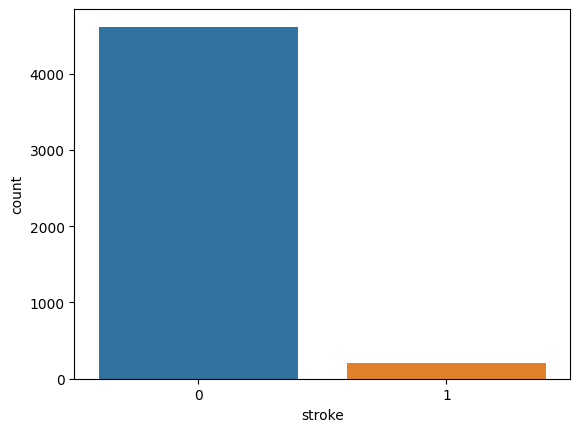

In [13]:
sns.countplot(data = df, x = 'stroke')

<Axes: xlabel='bmi'>

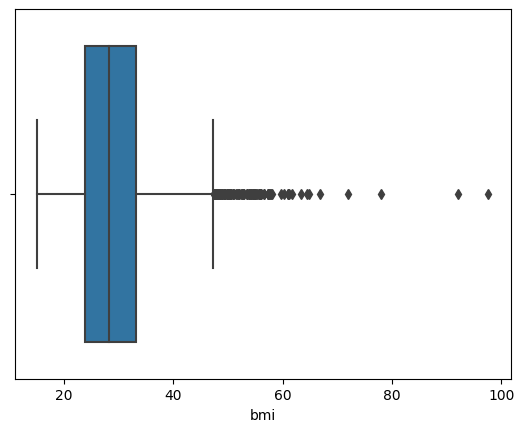

In [14]:
sns.boxplot(df, x ='bmi')

<Axes: xlabel='count', ylabel='ever_married'>

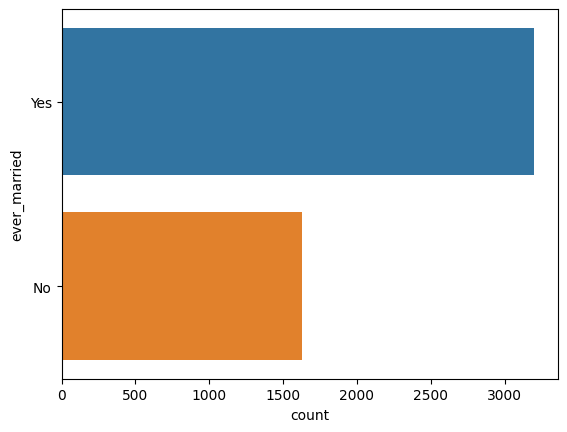

In [15]:
sns.countplot(data=df, y = 'ever_married')

<Axes: xlabel='age', ylabel='stroke'>

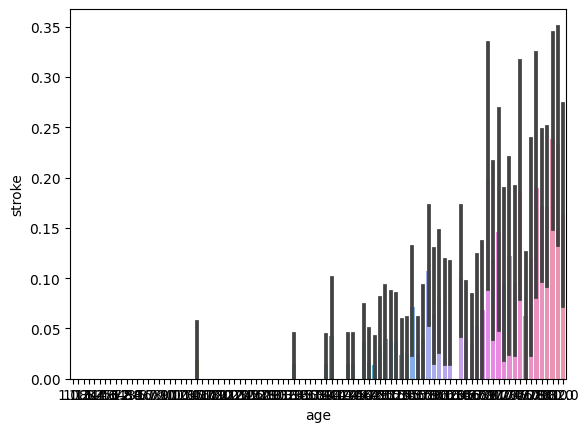

In [16]:
sns.barplot(data=df, x = 'age', y = 'stroke')

<Axes: xlabel='stroke', ylabel='hypertension'>

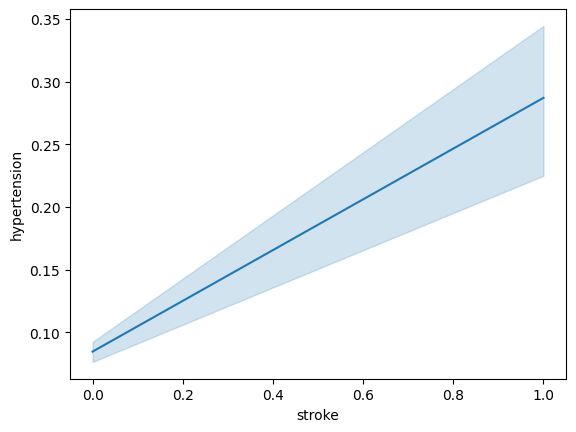

In [17]:
sns.lineplot(data=df, y = 'hypertension', x = 'stroke')

<Axes: ylabel='avg_glucose_level'>

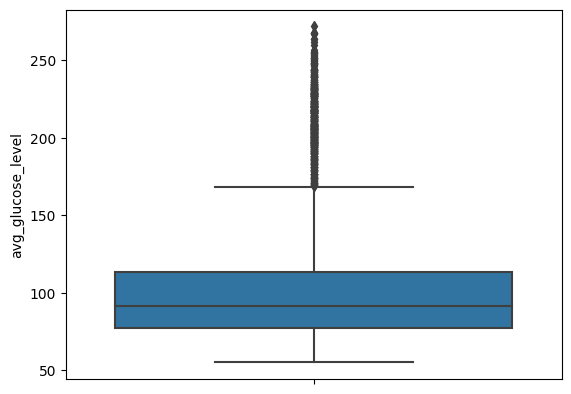

In [18]:
sns.boxplot(data=df, y = 'avg_glucose_level')

<Axes: xlabel='stroke', ylabel='smoking_status'>

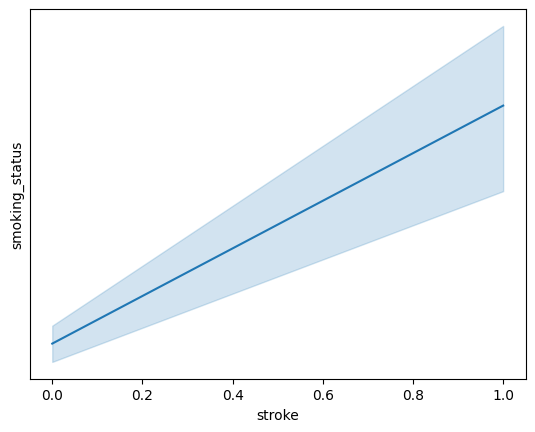

In [19]:
sns.lineplot(data=df, y = 'smoking_status', x = 'stroke')

<Axes: xlabel='work_type', ylabel='count'>

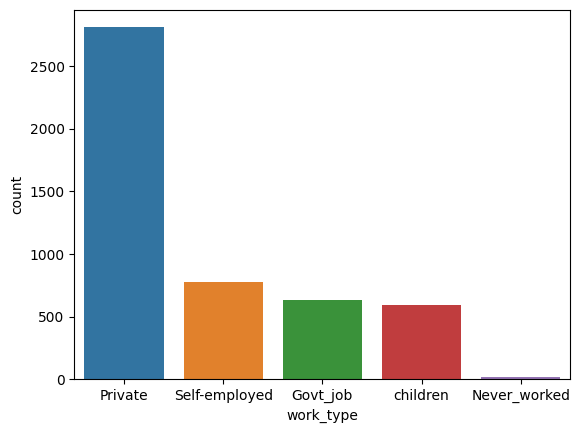

In [20]:
sns.countplot(data = df, x = 'work_type')

<Axes: xlabel='Residence_type', ylabel='stroke'>

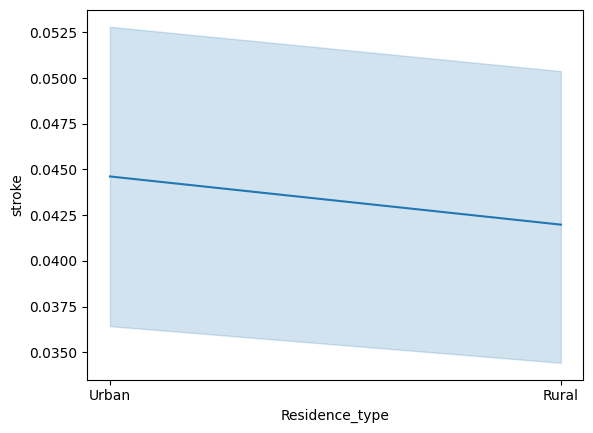

In [21]:
sns.lineplot(data = df, x = 'Residence_type', y = 'stroke')

<Axes: xlabel='age'>

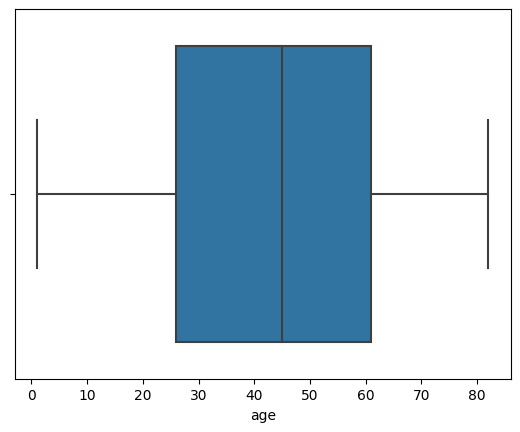

In [22]:
sns.boxplot(data = df, x = 'age')

<Axes: xlabel='smoking_status', ylabel='count'>

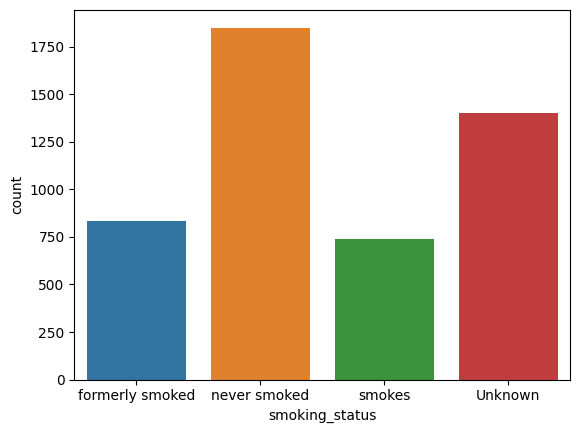

In [23]:
sns.countplot(data = df,x = 'smoking_status')

<Axes: xlabel='bmi', ylabel='count'>

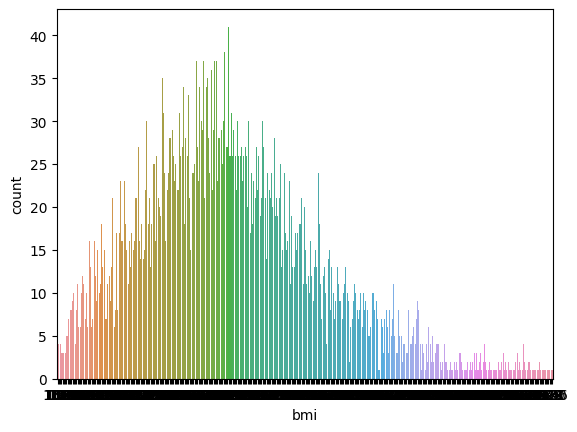

In [24]:
sns.countplot(data = df, x = 'bmi')

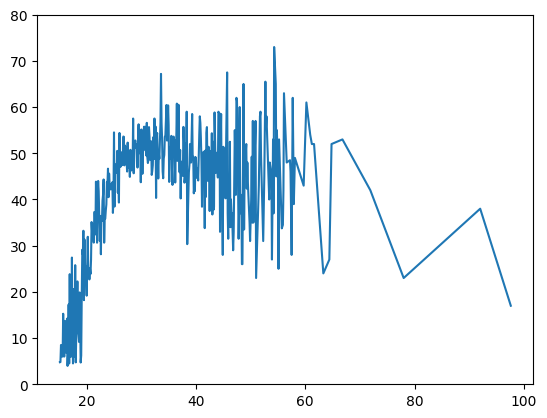

In [25]:
bmi_avg_age=df.groupby(['bmi'])[['age']].mean()
plt.plot(bmi_avg_age)
plt.yticks(range(0,int(df['age'].max()),10));


#Part 3

<ipython-input-26-0c6989c3ace4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap='Purples',annot=True);


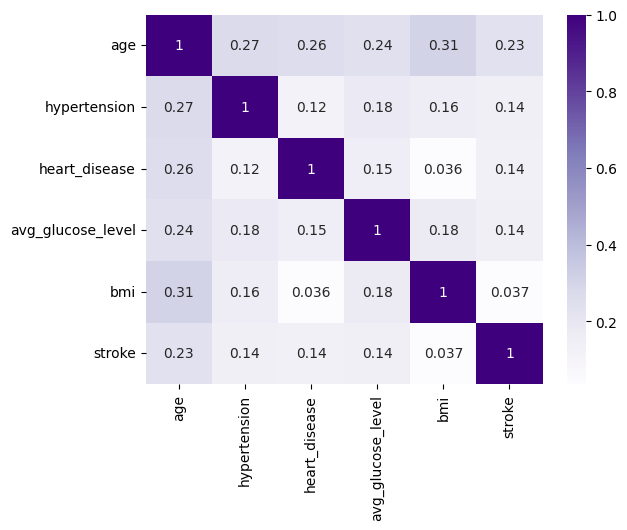

In [26]:
sns.heatmap(df.corr(),cmap='Purples',annot=True);

There is a very low correlation between features and between features and target across the board. None of our features have a correlation of greater than 0.31. The feature with the highest correlation to our 'stroke' target is 'age' with a correlation of 0.23. 

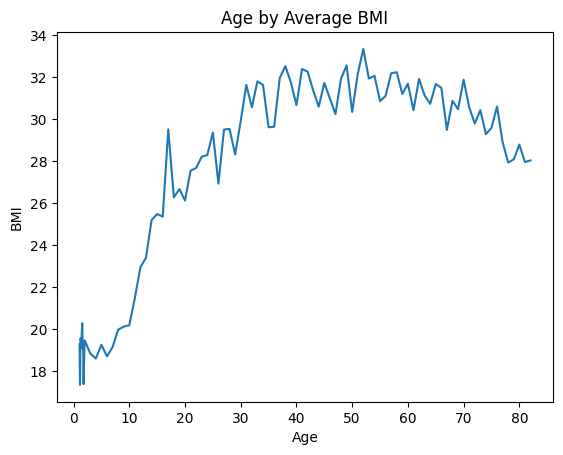

In [27]:
group_age_avg_bmi=df.groupby('age')['bmi'].mean()
plt.plot(group_age_avg_bmi)
plt.ylabel('BMI')
plt.xlabel('Age')
plt.title('Age by Average BMI')
plt.show();

**Trend**:

This plot shows a positive correlation between age and average bmi. The data shows that average bmi increase as age does. Of all features, 'age' has the strongest correlation with our target, 'stroke'. In a way, this correlation demonstrates that having a higher BMI increases the risk of having a stroke.

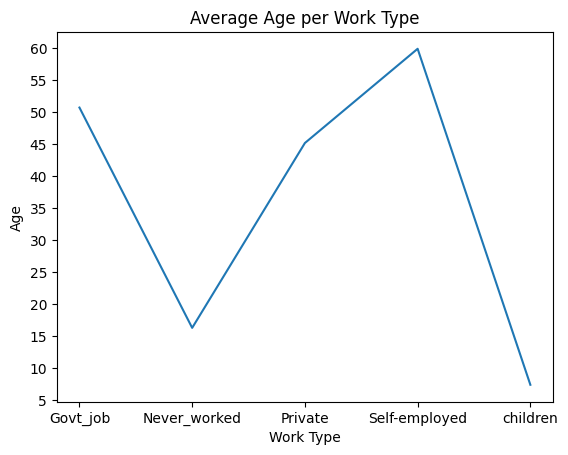

In [28]:
group_work_type_avg_age=df.groupby('work_type')['age'].mean()
plt.plot(group_work_type_avg_age)
plt.title('Average Age per Work Type')
plt.xlabel('Work Type')
plt.ylabel('Age')
plt.yticks(range(5,65,5))
plt.show();

**Trend**:

This plot shows that patients with presumably higher stressful occupations are also older on average. This means that there is an indirect link from 'work_type' and our 'stroke' target. The previously shown heatmap shows the highest correlation between age and risk of stroke. 

# Preprocessing

In [29]:
## Model Validation
# Defining target and features
y=df['stroke']
X=df.drop(columns='stroke')
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape

(3618, 10)

In [30]:
# Column selectors
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')
# Individual transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
# Tuples
num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)
# Column Transformer
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
X_train=col_transformer.fit_transform(X_train)
X_test=col_transformer.transform(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data is fully preprocessed and ready for modeling

# Modeling

In [31]:
# Instantiating default classification models
knn=KNeighborsClassifier()
logreg=LogisticRegression()
# Fitting 
knn.fit(X_train, y_train)
logreg.fit(X_train, y_train)
# Obtaining predictions
# KNN
knn_train_preds=knn.predict(X_train)
knn_test_preds=knn.predict(X_test)
# Logreg 
logreg_train_preds=logreg.predict(X_train)
logreg_test_preds=logreg.predict(X_test)

In [32]:
# Knn Scores
print('Train Scores:',classification_report(y_train, knn_train_preds))
print('\nTest Scores:',classification_report(y_test, knn_test_preds))

Train Scores:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3472
           1       0.62      0.03      0.06       146

    accuracy                           0.96      3618
   macro avg       0.79      0.52      0.52      3618
weighted avg       0.95      0.96      0.94      3618


Test Scores:               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1144
           1       0.40      0.03      0.06        63

    accuracy                           0.95      1207
   macro avg       0.67      0.51      0.52      1207
weighted avg       0.92      0.95      0.93      1207



Default model has incredibly poor recall and precision scores. It had a difficult time predicting strokes.

In [33]:
# Logreg Scores
print('Train Scores:',classification_report(y_train, logreg_train_preds))
print('\nTest Scores:',classification_report(y_test, logreg_test_preds))

Train Scores:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3472
           1       1.00      0.01      0.01       146

    accuracy                           0.96      3618
   macro avg       0.98      0.50      0.50      3618
weighted avg       0.96      0.96      0.94      3618


Test Scores:               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1144
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1207
   macro avg       0.47      0.50      0.49      1207
weighted avg       0.90      0.95      0.92      1207



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Just like the previous KNN default model, the LogisticRregression default model has terrible recall and precision. Even lower than that of the previous model. It too, had a difficult time predicting strokes.

# Tuning using GridSearchCV

## KNN 

In [34]:
# KNN 
# making a parameter grid to tune n_neighbors, p value, and weights:
# knn_params={'kneighborsclassifier__n_neighbors': range(1,10),
#            'kneighborsclassifier__p': range(1,5),
#            'kneighborsclassifier__weights': ['distance','uniform']}
knn_params={'n_neighbors': range(1,10),
           'p': range(1,5),
           'weights': ['distance','uniform']}
# Making KNN gridsearch pipeline
knn_pipe_gs=GridSearchCV(knn,knn_params)
knn_pipe_gs.fit(X_train, y_train) # fitting
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_) # grabbing best parameters
knn_gs_best = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {knn_gs_best.score(X_test, y_test)}')


KeyboardInterrupt: ignored

In [ ]:
## Tuned KNN Model
# Instantiating tuned KNN model
knn_tuned=KNeighborsClassifier(n_neighbors=4,p=4,weights='uniform')
knn_tuned.fit(X_train, y_train) #fitting 
# Obtaining new predictions
tuned_knn_train_preds=knn_tuned.predict(X_train)
tuned_knn_test_preds=knn_tuned.predict(X_test)
# Getting scores for tuned model
# Knn Scores
print('Train Scores:',classification_report(y_train, tuned_knn_train_preds))
print('\nTest Scores:',classification_report(y_test, tuned_knn_test_preds))

Even after hyperparameter tuning there is no real improvement in in our recall or precision in either our test or training set. 

## LogisticRegression

In [ ]:
# LogisticRegression
# making a parameter grid to tune solver, penalty, and regularization strength:
logreg_params={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           'penalty': ['l1','l2', 'none'],
           'C': [.001,.01,.1,1]}
# Making KNN gridsearch pipeline
logreg_pipe_gs=GridSearchCV(logreg,logreg_params)
logreg_pipe_gs.fit(X_train, y_train) # fitting
print('Best LogReg Parameters:')
print(logreg_pipe_gs.best_params_) # grabbing best parameters
logreg_gs_best = logreg_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {logreg_gs_best.score(X_test, y_test)}')


In [ ]:
## Tuned LogReg Model
# Instantiating tuned KNN model
logreg_tuned=LogisticRegression(C= 0.001, penalty= 'none', solver= 'newton-cg')
logreg_tuned.fit(X_train, y_train) #fitting 
# Obtaining new predictions
tuned_lr_train_preds=logreg_tuned.predict(X_train)
tuned_lr_test_preds=logreg_tuned.predict(X_test)
# Getting scores for tuned model
# Logreg Scores
print('Train Scores:',classification_report(y_train, tuned_lr_train_preds))
print('\nTest Scores:',classification_report(y_test, tuned_lr_test_preds))


Since both of our models performed poorly after hyperparameter tuning, we will move on to feature engineering using PCA to try to obtain higher precision and recall scores.

# PCA

In [ ]:
## Choosing the Number of Components to Return before modeling:
# Re-preparing data for PCA
X_processed=col_transformer.fit_transform(X)
# Instantiating and fitting PCA onto our data
pca= PCA()
pca.fit(X_processed)

In [ ]:
pca.explained_variance_ratio_.shape # determining number of components

In [ ]:
# Visualizing each principal component using Scree Plot:
# Plotting explained variance ratios of the first 21 principal components
plt.plot(range(1, 22), pca.explained_variance_ratio_, marker = '.')
plt.xticks(ticks = range(1, 22), fontsize=8)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')


10 principal components seems to explain enough variance without losing too much 


## KNN

In [ ]:
# Modeling with tuned KNN model and specified PCA 
pca_transformer=make_pipeline(ohe,scaler,PCA(n_components=10))
# new knn pipeline
knn_pca_pipe=make_pipeline(pca_transformer,knn_tuned)
knn_pca_pipe.fit(X_train,y_train)
# Evaluating model
print('Train Scores:',classification_report(y_train, knn_pca_pipe.predict(X_train)))
print('\nTest Scores:',classification_report(y_test, knn_pca_pipe.predict(X_test)))

## LogisticRegression

In [ ]:
# Modeling with tuned LogReg model and PCA 
# new logreg pipeline
lr_pca_pipe=make_pipeline(pca_transformer,logreg_tuned)
lr_pca_pipe.fit(X_train,y_train)
# Evaluating model
print('Train Scores:',classification_report(y_train, lr_pca_pipe.predict(X_train)))
print('\nTest Scores:',classification_report(y_test, lr_pca_pipe.predict(X_test)))

# Choosing a Model

If I were to choose a model of the two utilized, I would most definitely choose the default KNeighborsClassifier for the data.
I'd choose this due to the model having the highest of all metrics, but most importantly the highest recall. The model with the highest recall, in the context of the data, is going to be the one with the least amount of false negatives. Less false negatives means less patients deemed "likely to get stroke." 

When comparing both our KNeighborsClassifier model and our LogisticRegression model, after tuning multiple hyperparameters for each using GridSearchCV, and after completing feature extraction using PCA we see that there is no significant change in metrics, especially in our poorest performing metrics. In fact, our recall scores in our test set actually dropped from 0.06 in the default KNN Model to 0.03 after hyperperamater tuning. After applying PCA with 10 components, it dropped to 0.

One major takeaway from the data is that there simply isn't high enough correlation between features and between features and our target to for any model to demonstrate any significant predictive power. This is evident in the extremely low recall scores(our most important metrics for the data). With low recall scores like these, there would be a dangerously large amount of patients that wouldn't be considered at risk for stroke when they actually are. 